###### Build an email prioritization model

Priority can be defined as how quick an email needed to be dealt with, the content of the email, how quickly it was responded to etc. There's no ground truth on priority, with the hints previously mentioned, you'll need to create your own ground truth (target labels) on priority and explain the rationale behind this. 

The features you can use is left open, how you model the problem is also left open. We'd say, start with something simple first.

Evaluation:  We want to see for a given email that your model has never seen, how good the model is in determining the email's priority. It's recommended that you keep a portion of the dataset here to evaluate your model. Feel free to use standard metrics or create a new ones.

Email if you have any questions

In [108]:
## https://docs.python.org/3/library/datetime.html
from datetime import datetime
def to_timestamp(d):
    ''' Given an ISO format date string, convert to unix timestamp '''
    return datetime.timestamp(datetime.fromisoformat(d))

def to_datetime(d):
    ''' Given an ISO format date string, convert to datetime object '''
    return datetime.fromisoformat(d)

In [164]:
import nltk
nltk.download('brown')
import re, difflib
from sklearn.neighbors import KDTree
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences


from nltk.tokenize import word_tokenize

def strip_spaces(s):
    return re.sub('[ ]+', ' ', s).strip()

def ContentExtraction(mail, ContentSplitters):
    lmtr = [lmtr for lmtr in ContentSplitters if lmtr in mail.lower()]
    if len(lmtr)>0:
        limiter = re.search(lmtr[0], mail.lower()).start()
        return mail[:limiter]
    return mail

def Remove_URLs(x):
    x = word_tokenize(x)
    x = [i for i in x if not len(re.findall(r'[\w\.-]+@[\w\.-]+',i))]
    x = ' '.join(x)
    return x


def preprocess_mail(text, punctuation=False):
    text = re.sub('[^A-Za-z0-9 ,.]+', '', text.replace('\n',' ')).lower()
    text = strip_spaces(text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = text.replace(',',' , ').replace('.',' . ')
    text = ContentExtraction(text, ContentSplitters)
    text = Remove_URLs(text)
    if punctuations:
        text = re.sub('[^A-Za-z0-9 ]+', '', text.replace('\n',' ')).lower()
    
    return text


ContentSplitters  = ['best regards', 'rgds ','b rgds', '\ngreetings', '\nthanks.', '\nthanks,', '\nthank you','\nthank you,', '\nthank you\n', 'sincerely', 'regard ',
                      'regards', 'kind regards', 'the information contained in this','forwarded', '\ntel:', '\nMobile:', '\nall the best,','\ncordially',
                      '[image: image.png]','thx','Tel:','Fax:','greeting', '\nproject manager ', 'from:', 'envoyé :', 
                      'the information contained in this email are confid', '------- forwarded message -----', 
                      'proprietary and confidential.','\nthanks a lot', 'tel. ','Please consider your environmental responsibility',
                      'The administrator of your personal data','the information transmitted in this e-mai',  'Deze email en de bijgevoegde', 'this e-mail is intended only for the person or entity']



In [165]:


class Trie:
    head = {}

    def add(self,word):

        cur = self.head
        for ch in word:
            if ch not in cur:
                cur[ch] = {}
            cur = cur[ch]
        cur['*'] = True

    def search(self,word):
        cur = self.head
        for ch in word:
            if ch not in cur:
                return False
            cur = cur[ch]

        if '*' in cur:
            return True
        else:
            return False
    def printf(self):
        print (self.head)

# %%timeit
# trie_dict.search("paper")
# 503 ns ± 1.57 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
# %%timeit
# 'paper' in words1
# 1.26 ms ± 76.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


def get_nearest_word(search_w, stopwords, words1, excess=1000):

#     words1 = [list(map(ord, i)) for i in set(words)]
#     max_length = max(map(len, words1))
#     words1 = pad_sequences(words1, max_length)
#     tree = KDTree(words1, leaf_size=8)
    if search_w in stopwords:
        return [search_w, 1]
    dist = 0
    left = 0
    right = len(words1)
    while left<=right:
        mid = (left+right)//2
        d = difflib.SequenceMatcher(None, search_w ,words1[mid]).ratio()
        if d==1:
            break
        elif d<dist:
            left =  mid + 1
        else:
            dist = d
            right = mid - 1
    
    dist = ['',0, 0]
    for ind, w in enumerate(words1[mid-excess:mid+excess]):
        d = difflib.SequenceMatcher(None, search_w, w).ratio()
        if d==1:
            dist = [w, d]
            return dist
        if d>dist[1]:
            dist = [w, d]
    return dist

def concatenate_words(s, i, stopwords, words1, excess, word_size=9):
    te = []
    for j in [0,-1]:
        search_w = []
        if j==-1 and i>0:
            search_w.append(s[i-1])
        threshold = 0
        for ind, w in enumerate(s[i:]):
            
            if threshold>word_size: break
            threshold+=len(w)
            search_w.append(w)
#             print(search_w)
#             print(''.join(search_w) in words1)
#             r = get_nearest_word(''.join(search_w), stopwords, words1, excess=excess)
            
#             if r[1]==1:
#                 return ind+1, r[0], j
#             te.append(r)
#             if ''.join(search_w) in words1: #r[1]==1:
            if trie_dict.search(''.join(search_w)):
                return ind+1, ''.join(search_w), j
            
    return None, '', None



def sequence_processing(s, stopwords, words1, excess, word_size=6):
    res = []
    w = 0
    while w<len(s):
        # d = get_nearest_word(s[w], stopwords, words1, excess=excess)
        if trie_dict.search(s[w]):
            res.append(s[w])
        else:
            d1 = concatenate_words(s, w, stopwords, words1, excess, word_size)
            if d1[2]==-1:
                res.pop()
                res.append(d1[1])
            elif d1[2]==0:
                res.append(d1[1])
                w += d1[0]
            else:
                res.append(s[w])
        w +=1
    return ' '.join(res)


# %%time
# s = 'wion is un iquely positioned as the globa l voice of ind ia , present ing its own perspective on international issues of critical significance .'
# sequence_processing(s.split(' '), stopwords, words1, tune)
# before code optimization
# Wall time: 8.43 s

# after code optimization
# 38.2 µs ± 893 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)




trie_dict = Trie()
for word in words1:
    if '*' not in word:
        trie_dict.add(word)




# ml['text'] = ml['body'].apply(preprocess_mail)
# x = ml.sample(1).iloc[0]
# s = nltk.tokenize.sent_tokenize(x['text'])[0]

        


In [ ]:
df['mail'] = np.where((df['time_rsp']-df['time'])<pd.to_timedelta('1s'), df['body_rsp'], df['body'])
df['text'] =df['mail'].apply(preprocess_mail)
df['target'] = df['time_rsp'].subtract(df['time']).dt.total_seconds().abs()

In [160]:
# x = ml.sample(1).iloc[0]
sents = []
lr=4000
for s in nltk.tokenize.sent_tokenize(x['text']):
    sent = sequence_processing(s.split(' '), stopwords, words1, lr)
    sents.append(sent)

In [163]:
x = ml.sample(1).iloc[0]
print(x['body'])

---------             (b) (6)   >
Hi,
NIAD doesn't have ongoing trials with chloroquine and I heard that such tr ials are being conducted in
China.
We are planning to evaluate chloroquine in animal models ASAP. If any the rapeutic with a good clinical
safety profile ( like chloroquine) appears to be effective in vivo against COVID-19, we are planning to
quickly add to them to the Remdesivi r therapeutic trial as another arm.
Let me know if you have other questions .
Kind regards,
Cristina
Cristina Cassetti, Ph.D.
Deputy Director
Division of Microbiology and Infectious Diseases
National Institute of Allergy and Infectious Diseases, NIH
560 1 Fishers Lane, Room 7GS1
Rockville , MD 20852
Tel:             (b)(6)
(b)(6)


In [157]:
x['text']

'importance high dr  fauci of course  i appreciate how busy you are  so just reaching out again on behalf of the american college of cardiology as noted below  we were hopeful we could steal just an hour of your t ime in june for an important discussion on covid19 and exercise training  this is part of a virtual agenda for one of our national conferences care of the athletic heart with outreach around the world given this is a part of the acc educational platform  we hope th is is something you have the bandwidth for  and simply apprec iate your consideration  i hope to hear from you and thank you for all your service once again  my best  jonathan kim jonathan h  kim md  msc  facc chief of sports cardiology department of medicine  division of cardiology department of orthopedics emory university adju nct assistant professor division of applied physiology georgia inst itute of technology team cardiologist for emory athlet ics  georgia tech athletics  atlanta falcons  atlanta hawks  atla

In [155]:
%%timeit
s = 'wion is un iquely positioned as the globa l voice of ind ia , present ing its own perspective on international issues of critical significance .'
sequence_processing(s.split(' '), stopwords, words1, tune, word_size=10)

38.2 µs ± 893 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
import pickle
email_chain_pairs = pickle.load(open('email_chains.pkl','rb'))

In [ ]:
# email_chain_pairs: List of tuples with (recieved email, action from Fauci - reply/fwd etc)

In [5]:
stopwords = nltk.corpus.stopwords.words('english')

words = nltk.corpus.brown.words()
words1 = []
for w in words:
    w = w.lower()
    w = re.sub('[0-9]','', w)
    words1.append(w)
words1 = list(set(words1))
words1.sort()

In [6]:
ec = email_chain_pairs
ml = pd.DataFrame([i[0] for i in ec])
rs = pd.DataFrame([i[1] for i in ec])


In [7]:
ml['time']= pd.to_datetime(ml['time'], utc=True)
rs['time'] = pd.to_datetime(rs['time'], utc=True)
df = ml.join(rs.add_suffix('_rsp'))
df['target'] = df['time_rsp'] - df['time']

In [8]:
i = 345


In [9]:
df['uniqueID'] = df[['sender', 'time', 'subject']].astype(str).apply(' - '.join,1)
df['uniqueID_rsp'] = df[['sender_rsp', 'time_rsp', 'subject_rsp']].astype(str).apply(' - '.join,1)

In [10]:
df = df.sort_values('time')
df = df[~df[['uniqueID','uniqueID_rsp']].duplicated()]
seq = []
for ind, row in df.iterrows():
    li = [[row['uniqueID'], row['time'].timestamp()], [row['uniqueID_rsp'], row['time_rsp'].timestamp()]]
    seq.append(sorted(li, key=lambda x: x[1]))

In [11]:
seq[0][0]

['314 - 2019-12-19 04:24:00+00:00 - ', 1576729440.0]

In [12]:
def recur(sq, key, res):
    print(key)
    for s in range(len(sq)):
        print(sq[s][2])
        if sq[s][2]==0 and sq[s][0][0]==key:
            print('got in')
            sq[s][2] = 1
            sq, res = recur(sq, sq[s][1][0], res+[sq[s][0][0]])
    return sq, res
        
        
        

In [222]:
results = []
for i in range(len(seq))[:3]:
    if key == seq[i][1][0]:
        print('found')
#     if seq[i][2]==0:
#         seq[i][2]=1
#         seq, res = recur(seq, seq[i][1][0], [seq[i][1][0]])
#         results.append(res)

found


In [13]:
df1 = pd.concat([ml, rs])

In [166]:

# def Remove_URLs(x):
#     x = word_tokenize(x)
#     x = [i for i in x if not len(re.findall(r'[\w\.-]+@[\w\.-]+',i))]
#     x = ' '.join(x)
#     return x


# def ContentExtraction(mail, ContentSplitters):
#     lmtr = [lmtr for lmtr in ContentSplitters if lmtr in mail.lower()]
#     if len(lmtr)>0:
#         limiter = re.search(lmtr[0], mail.lower()).start()
#         return mail[:limiter]
#     return mail

# def PreprocessMails(mails, content=False):
#     ProcessedMails = []
#     for mail in mails:
#         import re
#         text = re.sub(r'^https?:\/\/.*[\r\n]*', '', mail, flags=re.MULTILINE)
#         text = ContentExtraction(text, ContentSplitters)
#         text = Remove_URLs(text)
#         if content:
#             ProcessedMails.append(text)
#             continue
#         text = tokenize(text)
#         text = Lemmatization(text)
#         ProcessedMails.append(' '.join(text))
#     return ProcessedMails

# def FilterWords(text, tokens=None, Nouns=False):
#     Verbs = ['VB','VBP','RB','VBN']
#     text_tokens = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
#     if isinstance(tokens,str) and tokens=='nouns':
#         verbs = [i[0] for i in text_tokens if i[1].startswith('NN') or i[1]=='CD']
#     elif isinstance(tokens,str) and tokens=='verbs':
#         verbs = [i[0] for i in text_tokens if i[1] in Verbs]
#     else:
#         verbs = [i[0] for i in text_tokens if i[1] in tokens]
#     return ' '.join(verbs)

# def POS_Extract(mails, parts='verbs', content=False):    
#     ProcessedMails = PreprocessMails(mails, content=content)
#     text = ' '.join(ProcessedMails)
#     if content:
#         return text
#     text = FilterWords(text, tokens=parts)
#     return text

# def ContentExtraction(mail, ContentSplitters):
#     lmtr = [lmtr for lmtr in ContentSplitters if lmtr in mail.lower()]
#     if len(lmtr)>0:
#         limiter = re.search(lmtr[0], mail.lower()).start()
#         return mail[:limiter]
#     return mail

# # Prioritize the Delimiter with Thanks and Regards like
# MailSplitters = 'Subject:|Envoyé :'
# ContentSplitters  = ['best regards', 'rgds ','b rgds', '\ngreetings', '\nthanks.', '\nthanks,', '\nthank you','\nthank you,', '\nthank you\n', 'sincerely', 'regard ',
#                       'regards', 'kind regards', 'forwarded', '\ntel:', '\nMobile:', '\nall the best,','\ncordially',
#                       '[image: image.png]','thx','Tel:','Fax:','greeting', '\nproject manager ', 'from:', 'envoyé :', 
#                       'the information contained in this email are confid', '------- forwarded message -----', 
#                       'proprietary and confidential.','\nthanks a lot', 'tel. ','Please consider your environmental responsibility',
#                       'The administrator of your personal data','the information transmitted in this e-mai',  'Deze email en de bijgevoegde', 'this e-mail is intended only for the person or entity']

# Delimiters = '|'.join(['Lastone','regards','Sincerely', 'Thank','Forwarded', 'The Information', 
#                        'tel-mob-email-mobile', 'greeting', 'please note', 'thx', 'Tel:','Fax:'])
# # # df = pd.read_excel(r'D:\Notsaved\viswanadhapa\Downloads\Ticket data.xlsx')
# # df2 = df1.loc[df1['T_Description'].ne('None')]
# # df2['DescriptionMails'] = df2['T_Description'].fillna('').apply(PreprocessSplitMails)  #.str.split('Subject:|Envoyé :')#.apply(lambda text: [re.split(Delimiters, te)[0] for te in text])

In [20]:
def PreprocessMails(mails, content=False):
    ProcessedMails = []
    for mail in mails:
        import re
        text = re.sub(r'^https?:\/\/.*[\r\n]*', '', mail, flags=re.MULTILINE)
        text = ContentExtraction(text, ContentSplitters)
        text = Remove_URLs(text)
        if content:
            ProcessedMails.append(text)
            continue
        text = tokenize(text)
        text = Lemmatization(text)
        ProcessedMails.append(' '.join(text))
    return ProcessedMails


In [ ]:
text = re.sub(r'^https?:\/\/.*[\r\n]*', '', mail, flags=re.MULTILINE)
text = ContentExtraction(text, ContentSplitters)
text = Remove_URLs(text)


In [103]:
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\nagak\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nagak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nagak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [83]:
string1 = "clicking"
string2 = "clicking"

temp = difflib.SequenceMatcher(None,string1 ,string2)

print(temp.get_matching_blocks())
print('Similarity Score: ',temp.ratio())

[Match(a=0, b=0, size=8), Match(a=8, b=8, size=0)]
Similarity Score:  1.0


In [106]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline

from sklearn.model_selection import train_test_split


import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

def preprocesse_text(df, test_size=0.2, stopwords=[]):
    train_text,test_text,y_train,y_test = train_test_split(df['text'], df['target'], test_size=test_size)

    all_text = pd.concat([train_text, test_text])

    word_vectorizer = TfidfVectorizer(
        sublinear_tf=True,
        strip_accents='unicode',
        analyzer='word',
        token_pattern=r'\w{1,}',
        stop_words=stopwords,
        ngram_range=(1, 6),
        max_features=35000)
    word_vectorizer.fit(all_text)
    train_word_features = word_vectorizer.transform(train_text)
    test_word_features = word_vectorizer.transform(test_text)

    char_vectorizer = TfidfVectorizer(
        sublinear_tf=True,
        strip_accents='unicode',
        analyzer='char',
        stop_words=stopwords,
        ngram_range=(5, 6),
        max_features=10000)
    char_vectorizer.fit(all_text)
    train_char_features = char_vectorizer.transform(train_text)
    test_char_features = char_vectorizer.transform(test_text)

    train_features = hstack([train_char_features, train_word_features])
    test_features = hstack([test_char_features, test_word_features])
    return train_features, test_features, train_word_features, train_char_features, y_train, y_test, test_text, word_vectorizer, char_vectorizer

In [107]:
from sklearn.linear_model import LinearRegression

train_features, test_features, train_word_features, train_char_features, y_train, y_test, test_text, word_vectorizer, char_vectorizer = preprocesse_text(df, test_size=0.2, stopwords=nltk.corpus.stopwords.words('english'))

reg = LinearRegression()
cv_score = np.mean(cross_val_score(reg, train_features, y_train.values, cv=3, scoring='r2'))
reg.fit(train_features, y_train)

C:\Users\nagak\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:497: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


<AxesSubplot:>

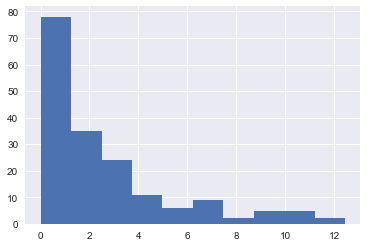

In [84]:

from sklearn.linear_model import LinearRegression
reg = LinearRegression()
cv_score = np.mean(cross_val_score(reg, train_features, y_train.values, cv=3, scoring='r2'))
reg.fit(train_features, y_train)

te = pd.DataFrame()
te['text'] = test_text
te['preds'] = reg.predict(test_features)
te['target'] = y_test
te['diff'] = te['target']-te['preds']
te['percent'] = te['diff'].abs().div(te['target'])
te = te.sort_values('percent')
te.iloc[:int(len(te)*0.9)]['percent'].hist()

In [85]:
features = pd.DataFrame()
features['weights'] = pd.Series(reg.coef_)
features['features'] = word_vectorizer.get_feature_names()+char_vectorizer.get_feature_names()
features['wgt'] = features['weights'].abs()

In [87]:
features['wgt'].describe()

count     45000.000000
mean      23458.074251
std       40298.754863
min           0.000000
25%        2550.395038
50%        8328.594305
75%       28152.683798
max      770848.134727
Name: wgt, dtype: float64

In [88]:
features['wgt'].std()

40298.75486335292

In [89]:
thr = features['wgt'].quantile(0.5)

In [90]:
std_p = 2
features[features['wgt'].gt(thr)].sort_values('wgt', ascending=False)['features'].tolist()[:15]

['icate',
 'dear mr varadara jan',
 'expedite execute whole hhs response',
 'human microbiome profe ssor medicine',
 'help sara',
 'b6 3014964409',
 'note dr',
 'urldefense proofpoint',
 'elected chair 2 years ministers',
 ' trea',
 'ed icu patients covid19 must',
 'one countrys',
 'b6 b',
 'would able take',
 'june important discussion covid19']

In [91]:
features[features['wgt'].lt(thr)].sort_values('wgt', ascending=False)['features'].tolist()[:15]

['developing infected covid19',
 'group idea future',
 'tered',
 ' devi',
 'even phase',
 'ent c',
 'leaders',
 ' a few',
 'g as ',
 'wnch111e session oncov 19 tue 310',
 'wnch111e session oncov 19 tue',
 'family',
 'wnch111e session oncov 19',
 'n for',
 'n for ']

In [92]:
features['gram_type'] = ['ngrams']*train_char_features.shape[1] + ['char grams']*train_word_features.shape[1]

In [93]:
features.groupby('gram_type')['wgt'].describe()

,count,mean,std,min,25%,50%,75%,max
gram_type,,,,,,,,
char grams,35000.0,17148.913012,35917.197102,0.000000,2206.358632,5469.385079,15448.952101,770848.134727
ngrams,10000.0,45540.138586,46540.757077,3.217177,14884.715923,33085.178872,58589.767678,601834.998813


In [94]:
features[:train_char_features.shape[1]].groupby(features['features'].str.split(' ').apply(len))['wgt'].describe()

,count,mean,std,min,25%,50%,75%,max
features,,,,,,,,
1,1852.0,45070.243919,44759.903113,3.238693,15074.730448,33409.543852,58055.357892,403086.447567
2,2164.0,44831.625747,46530.124360,3.217177,14855.636205,32982.987178,58099.061334,562273.234026
3,1637.0,46333.091109,46556.901531,8.397256,15093.396542,33854.692454,60146.969911,394521.470373
4,1507.0,46819.811846,50160.121468,89.464215,14728.302399,32641.000031,60193.119923,601834.998813
5,1440.0,45999.621937,46098.247212,3.238693,15059.111812,33362.165177,58715.885888,428129.550783
6,1400.0,44479.624158,45267.767879,3.238693,14416.613255,32699.576500,56231.869112,286769.553239


In [103]:
extra_stopwords = features[features['wgt'].lt(thr)].sort_values('wgt', ascending=False)['features'].tolist()

C:\Users\nagak\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['0', '000', '01', '01iginnted', '02', '02139', '0614g', '07', '0700', '08854', '1', '10', '100', '10003', '100125', '10036', '1007', '1011n248', '1015', '1019strategicp', '1021', '1046', '106a', '11', '110', '11012020', '1112', '1113', '113', '1140amlpm', '1194faa', '12', '120', '12026597931', '1211', '1212402', '123', '1250', '1299', '12pm', '13', '1300', '130pm', '134', '13th', '14', '1445', '14day', '1500', '1520', '15minute', '15minvte', '1616', '1640', '18', '19', '1918', '1927955', '1960', '197', '1985', '1992', '1998', '1b', '1md', '1nfecuouso1seases', '1pm', '1t', '1who', '2', '200', '2000', '20004', '20005', '2003', '2004', '2008', '200890045', '2009', '2010', '2017', '2018', '2019', '2019nco', '2019ncov', '2020', '20200303', '20200405b', '2021', '2023348387', '2024', '2031399059

C:\Users\nagak\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:497: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


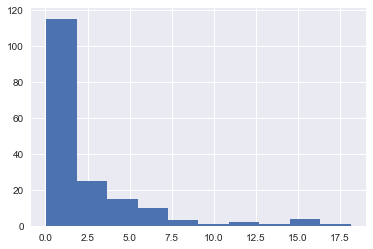

In [104]:


from sklearn.linear_model import LinearRegression
reg = LinearRegression()
cv_score = np.mean(cross_val_score(reg, train_features, y_train.values, cv=3, scoring='r2'))
reg.fit(train_features, y_train)

te = pd.DataFrame()
te['text'] = test_text
te['preds'] = reg.predict(test_features)
te['target'] = y_test
te['diff'] = te['target']-te['preds']
te['percent'] = te['diff'].abs().div(te['target'])
te = te.sort_values('percent')
te.iloc[:int(len(te)*0.9)]['percent'].hist()

features = pd.DataFrame()
features['weights'] = pd.Series(reg.coef_)
features['features'] = word_vectorizer.get_feature_names()+char_vectorizer.get_feature_names()
features['wgt'] = features['weights'].abs()

In [58]:
features[train_char_features.shape[1]:]

17847

In [52]:
features.shape

(37847, 3)

In [512]:
weights[weights.between(-weights.std()*0.3, weights.std()*0.3)].index

Int64Index([    6,     7,    10,    11,    12,    19,    20,    21,    22,
               23,
            ...
            37833, 37834, 37836, 37838, 37840, 37841, 37842, 37844, 37845,
            37846],
           dtype='int64', length=17478)

In [440]:
cv_score

-0.025804388020673974

In [ ]:
train_target = train[class_name]
classifier = LogisticRegression(C=0.1, solver='sag')



scores.append(cv_score)
print('CV score for class {} is {}'.format(class_name, cv_score))

classifier.fit(train_features, train_target)
submission[class_name] = classifier.predict_proba(test_features)[:, 1]


In [ ]:

for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1]

print('Total CV score is {}'.format(np.mean(scores)))

submission.to_csv('submission.csv', index=False)

In [427]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack


# train_text = train['comment_text']
# test_text = test['comment_text']
# all_text = pd.concat([train_text, test_text])
all_text = df['text']
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 4),
    max_features=30000)
word_vectorizer.fit(all_text)

TfidfVectorizer(max_features=30000, ngram_range=(1, 4), stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}')

In [428]:

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=20000)
char_vectorizer.fit(all_text)

C:\Users\nagak\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:497: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


TfidfVectorizer(analyzer='char', max_features=20000, ngram_range=(2, 6),
                stop_words='english', strip_accents='unicode',
                sublinear_tf=True)

In [426]:

word_vectorizer.get_feature_names()

['0',
 '0 2035',
 '0 2035 251028',
 '0 2035 251028 cell',
 '0 5',
 '0 b6',
 '00',
 '000',
 '000 000',
 '000 remain',
 '000 remain available',
 '01',
 '02',
 '03',
 '05',
 '06',
 '07',
 '08',
 '0mb',
 '1',
 '1 000',
 '1 1',
 '1 1 1',
 '1 1 1 1',
 '1 2',
 '1 2020',
 '1 58',
 '1 58 22',
 '1 58 22 07',
 '1 8',
 '1 8cineole',
 '1 clinical',
 '1 clinical trial',
 '1 pm',
 '1 pm tomorrow',
 '1 room',
 '1 room 138',
 '1 room 138 p',
 '10',
 '10 minutes',
 '100',
 '1002',
 '1002cbdv',
 '10036',
 '1007',
 '1007 stephen',
 '1007 stephen morrison',
 '1007 stephen morrison smorrisocs',
 '101',
 '1015',
 '1015 minute',
 '11',
 '11 12',
 '11012020',
 '113',
 '114',
 '1142',
 '115',
 '119',
 '12',
 '12 2020',
 '120',
 '120 pm',
 '1200',
 '121',
 '1210',
 '1210 pm',
 '123',
 '12pm',
 '13',
 '130',
 '1300',
 '130pm',
 '138',
 '138 p',
 '138 p b6',
 '138 p b6 m',
 '14',
 '14 days',
 '14day',
 '14day period',
 '15',
 '15 2020',
 '15 minute',
 '15 minutes',
 '150',
 '1500',
 '1520',
 '1520 minutes',
 '1520

In [ ]:
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [418]:
from sklearn.feature_extraction.text import CountVectorizer

In [419]:
ngram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(1, 4))

In [424]:
counts = ngram_vectorizer.fit_transform([['words', 'wprds']])

AttributeError: 'list' object has no attribute 'lower'

In [423]:
features = ngram_vectorizer.get_feature_names()
features

[' ',
 ' w',
 ' wo',
 ' wor',
 ' wp',
 ' wpr',
 'd',
 'ds',
 'ds ',
 'o',
 'or',
 'ord',
 'ords',
 'p',
 'pr',
 'prd',
 'prds',
 'r',
 'rd',
 'rds',
 'rds ',
 's',
 's ',
 'w',
 'wo',
 'wor',
 'word',
 'wp',
 'wpr',
 'wprd']

In [417]:
ngram_vectorizer.get_feature_names_out()

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names_out'

In [411]:
vectorizer = CountVectorizer()

In [ ]:
X = vectorizer.fit_transform(corpus)

In [409]:
import sklearn.feature_extraction.text
from nltk.tokenize import TreebankWordTokenizer

ngram_size = 4
string = ["I really like python, it's pretty awesome."]
vect = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(ngram_size,ngram_size), \
                                                 tokenizer=TreebankWordTokenizer().tokenize)
print('{1}-grams: {0}'.format(vect.get_feature_names(), ngram_size))

NotFittedError: Vocabulary not fitted or provided